In [22]:
import investpy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Get funds in Germany

In [2]:
funds = investpy.get_etfs(country='germany')

In [3]:
print(f"There are {len(funds)} funds avaliable in Germany")

There are 2217 funds avaliable in Germany


## I am mostly interested in accumulating BlackRock (and later Amundi) ETFs

So we are searching for iShares with Acc fields in the names. 

In [4]:
n = 0
for fund in funds.name:
    if (fund.find('iShares') != -1 and fund.find('Acc') != -1):
        if n == 0:
            df = investpy.etfs.get_etf_information(etf=fund, country='germany', as_json=False)
            n += 1
        else:
            df_2 = investpy.etfs.get_etf_information(etf=fund, country='germany', as_json=False)
            df = pd.concat([df,df_2])

There seems to be a lot of ETFs which are duplicated in the dataset. Let us first remove the rows with duplicate names.

In [5]:
df.drop_duplicates(subset='ETF Name', keep='first', inplace=True)

Check for NaNs in the information dataframes

In [6]:
df.head()

,ETF Name,Prev. Close,Todays Range,ROI (TTM),Open,52 wk Range,Dividends (TTM),Volume,Market Cap,Dividend Yield,Average Vol. (3m),Total Assets,Beta,1-Year Change,Shares Outstanding,Asset Class
0,iShares Digitalisation Acc,9.16,9.09 - 9.22,None,9.16,5.44 - 9.22,None,277770,None,None,297299,None,None,62.48%,None,Equity
0,iShares Digital Security UCITS Acc,6.15,6.15 - 6.19,None,6.16,4.33 - 6.22,None,153210,None,None,420866,None,None,38.43%,None,Equity
0,iShares Nasdaq US Biotechnology UCITS USD (Acc),5.77,5.72 - 5.79,None,5.75,4.8 - 6.44,None,269219,None,None,282235,None,None,13.62%,None,Equity
0,iShares MSCI World Small Cap UCITS USD Acc,6.05,6.05 - 6.09,None,6.07,3.67 - 6.09,None,691526,None,None,663003,None,None,60.87%,None,Equity
0,iShares MSCI USA ESG Screened UCITS Acc,6.77,6.77 - 6.81,None,6.78,4.7 - 6.81,None,149040,None,None,117599,None,None,39.22%,None,Equity


In [7]:
nan_columns = set(df.columns[df.isnull().mean() > 0])
all_nan_cols = set(df.columns[df.isnull().mean() == 1])
print(f"The columns that have NaNs are: {nan_columns}. And the fields which are all NaNs are: {all_nan_cols}. We drop the fields with all NaNs")

The columns that have NaNs are: {'Shares Outstanding', 'Market Cap', 'Dividends (TTM)', 'Average Vol. (3m)', 'Beta', 'Volume', 'Total Assets', 'Dividend Yield', 'Asset Class', 'ROI (TTM)'}. And the fields which are all NaNs are: {'Shares Outstanding', 'Market Cap', 'Dividends (TTM)', 'Beta', 'Total Assets', 'Dividend Yield', 'ROI (TTM)'}. We drop the fields with all NaNs


In [8]:
df = df.drop(all_nan_cols, axis=1);

In [9]:
print(f"We need to now sort out the {nan_columns-all_nan_cols} columns")

We need to now sort out the {'Volume', 'Asset Class', 'Average Vol. (3m)'} columns


Some of the columns which have NaNs are categorical - we leave them NaNs, the numerical columns we exchange NaNs with 0. 

In [10]:
for column in df.columns:
    print(f"{column} - {df[column].dtypes}")

ETF Name - object
Prev. Close - float64
Todays Range - object
Open - float64
52 wk Range - object
Volume - object
Average Vol. (3m) - object
1-Year Change - object
Asset Class - object


In [11]:
df[['Today-low','Today-high']] = df['Todays Range'].str.split('-',expand=True).astype('float')
df[['52w-low','52w-high']] = df['52 wk Range'].str.split('-',expand=True).astype('float')

In [12]:
df = df.drop(['Todays Range', '52 wk Range'], axis=1)

In [13]:
df[['Average Vol. (3m)', 'Volume']] = df[['Average Vol. (3m)', 'Volume']].astype('float')

In [14]:
df.head()

,ETF Name,Prev. Close,Open,Volume,Average Vol. (3m),1-Year Change,Asset Class,Today-low,Today-high,52w-low,52w-high
0,iShares Digitalisation Acc,9.16,9.16,277770.0,297299.0,62.48%,Equity,9.09,9.22,5.44,9.22
0,iShares Digital Security UCITS Acc,6.15,6.16,153210.0,420866.0,38.43%,Equity,6.15,6.19,4.33,6.22
0,iShares Nasdaq US Biotechnology UCITS USD (Acc),5.77,5.75,269219.0,282235.0,13.62%,Equity,5.72,5.79,4.80,6.44
0,iShares MSCI World Small Cap UCITS USD Acc,6.05,6.07,691526.0,663003.0,60.87%,Equity,6.05,6.09,3.67,6.09
0,iShares MSCI USA ESG Screened UCITS Acc,6.77,6.78,149040.0,117599.0,39.22%,Equity,6.77,6.81,4.70,6.81


In [15]:
df['1-Year Change'] = df['1-Year Change'].str.replace('- ', '-')
df['1-Year Change'] = df['1-Year Change'].str.rstrip(' % ').astype('float') / 100.0

In [16]:
for column in ['Volume', 'Average Vol. (3m)']:
    df[column] = df[column].fillna(0)

Fixing of data is done. Now we start with the analysis of the ETFs

In [17]:
df.describe()

,Prev. Close,Open,Volume,Average Vol. (3m),1-Year Change,Today-low,Today-high,52w-low,52w-high
count,28.000000,28.00000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,55.072214,55.04575,83769.964286,94847.571429,0.304714,54.989071,55.273036,45.623857,56.498607
std,63.049482,63.02161,156194.164009,176009.177032,0.207561,62.971877,63.192295,56.129886,64.579448
min,5.310000,5.27000,0.000000,0.000000,-0.055300,5.270000,5.270000,3.670000,5.470000
25%,6.413250,6.41800,244.500000,1848.250000,0.122925,6.412500,6.440500,4.595000,6.503000
50%,8.872000,8.87150,2459.000000,16169.000000,0.364950,8.782000,8.917500,5.678500,9.322500
75%,123.330000,123.28250,96588.750000,63056.500000,0.436125,123.282500,124.225000,92.712500,124.225000
max,173.420000,173.70000,691526.000000,663003.000000,0.630300,173.110000,173.700000,165.930000,177.600000


<AxesSubplot:>

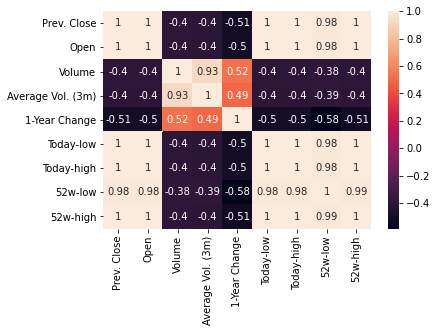

In [18]:
sns.heatmap(df.corr(), annot=True)

Not surprising there is a correlation between the volume and the 1-year change - more traded ETFs seem to be making more money for the investors.

## Let's have a look at which ETFs shall I invest in based on the historical values

Considering I do not have unlimited funds I will get the ETFs which have > 30% year to year change in the past year. This will be later extended to more old historical values. 

In [19]:
df_high_roi = df[df['1-Year Change'] > 0.3]

In [20]:
df_high_roi

,ETF Name,Prev. Close,Open,Volume,Average Vol. (3m),1-Year Change,Asset Class,Today-low,Today-high,52w-low,52w-high
0,iShares Digitalisation Acc,9.160,9.160,277770.0,297299.0,0.6248,Equity,9.090,9.220,5.440,9.220
0,iShares Digital Security UCITS Acc,6.150,6.160,153210.0,420866.0,0.3843,Equity,6.150,6.190,4.330,6.220
0,iShares MSCI World Small Cap UCITS USD Acc,6.050,6.070,691526.0,663003.0,0.6087,Equity,6.050,6.090,3.670,6.090
0,iShares MSCI USA ESG Screened UCITS Acc,6.770,6.780,149040.0,117599.0,0.3922,Equity,6.770,6.810,4.700,6.810
0,iShares S&P 500 Communication Sector USD Acc,6.810,6.820,5986.0,25668.0,0.4063,Equity,6.810,6.820,4.650,6.910
0,iShares Edge MSCI EMU Multifactor UCITS EUR (Acc),5.470,5.470,0.0,1072.0,0.3260,Equity,5.440,5.470,3.980,5.470
0,iShares S&P 500 Industrials Sector Acc,6.690,6.690,18937.0,33170.0,0.4938,Equity,6.690,6.720,4.210,6.760
0,iShares Automation & Robotics Acc,10.666,10.670,357702.0,524402.0,0.6303,Equity,10.626,10.720,6.346,10.946
0,iShares Ageing Population Acc,6.501,6.504,79105.0,74098.0,0.4361,Equity,6.500,6.524,4.410,6.524
0,iShares Healthcare Innovation Acc,8.584,8.583,243.0,5641.0,0.4058,Equity,8.474,8.615,5.917,9.425


### We can see that there are a lot of high RoI over the past year. But how does this compare over the historical data

/Users/shristov/opt/anaconda3/lib/python3.8/site-packages/investpy/etfs.py:587: Warning: Selected country does not contain the default stock exchange of the introduced ETF. Default country is: "united kingdom" and default stock_exchange: "London".
  warnings.warn(
/Users/shristov/opt/anaconda3/lib/python3.8/site-packages/investpy/etfs.py:587: Warning: Selected country does not contain the default stock exchange of the introduced ETF. Default country is: "united kingdom" and default stock_exchange: "London".
  warnings.warn(
/Users/shristov/opt/anaconda3/lib/python3.8/site-packages/investpy/etfs.py:587: Warning: Selected country does not contain the default stock exchange of the introduced ETF. Default country is: "united kingdom" and default stock_exchange: "London".
  warnings.warn(
/Users/shristov/opt/anaconda3/lib/python3.8/site-packages/investpy/etfs.py:587: Warning: Selected country does not contain the default stock exchange of the introduced ETF. Default country is: "italy" and 

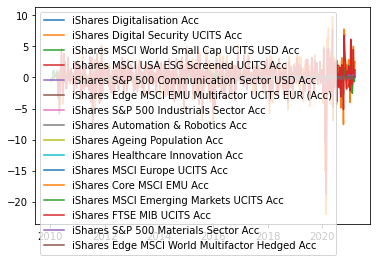

In [26]:
for etf in df_high_roi["ETF Name"]:
    df_temp = investpy.etfs.get_etf_historical_data(etf=etf, country='germany', from_date='01/01/2010', to_date='01/04/2021', interval='Weekly')
    plt.plot(df_temp.index[:-1],np.diff(df_temp['Close']), label=etf)
    plt.legend()